In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

In [14]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]


# Get data

In [5]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

df.head()

,AGCNr,logfgas
0,331061,-0.447361
1,101866,-1.089920
2,101869,-0.350810
3,331082,0.104468
4,101873,-0.153950


In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

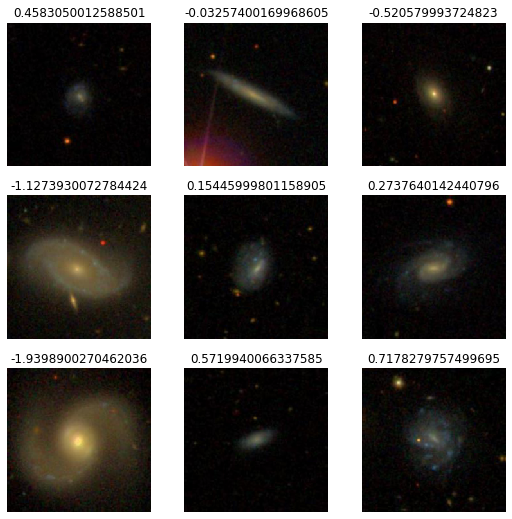

In [7]:
dls.show_batch()

# Train

In [8]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.009120108559727669)

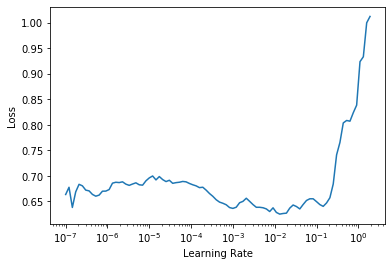

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.433506,0.369223,00:32
1,0.339782,0.342082,00:32
2,0.331865,0.444210,00:32
3,0.331396,0.316272,00:32
4,0.317954,0.339526,00:32
5,0.329791,0.302487,00:32
6,0.317036,0.355478,00:32
7,0.313325,0.488205,00:32
8,0.297874,0.303083,00:32
9,0.295228,0.286822,00:32


Wow, this does really well! ~0.22 dex on my first try, and we can probably do better (since validation loss < training loss)

In [11]:
# learn.save('fastai2-xresnet34-a40A-1')
learn = learn.load('fastai2-xresnet34-a40A-1')

# train deeper model for longer

In [8]:
model = xresnet50(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

In [9]:
learn.fit_one_cycle(40, 6e-3)

epoch,train_loss,valid_loss,time
0,0.433761,0.483216,00:48
1,0.441388,0.571268,00:48
2,0.442347,0.382038,00:48
3,0.366865,0.355116,00:48
4,0.343627,0.314396,00:48
5,0.353308,0.525885,00:48
6,0.334554,0.330933,00:48
7,0.320959,0.499540,00:48
8,0.316845,0.268747,00:48
9,0.312919,0.286743,00:48


KeyboardInterrupt: 

In [10]:
# learn.save('fastai2-xresnet50-a40A-1')
learn = learn.load('fastai2-xresnet50-a40A-1')

# Try predicting on NIBLES
see nb `01`

In [12]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)]

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)
nibles.nibles_id = nibles.nibles_id.astype(str)

In [15]:
nibles_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['nibles_id'], pref=f'{PATH}/images-nibles_cleaned/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [16]:
nibles_dls = ImageDataLoaders.from_dblock(nibles_dblock, nibles, path=PATH, bs=1)

In [17]:
nibles_preds, nibles_trues = learn.get_preds(dl=nibles_dls.train)

In [18]:
valid_preds, valid_trues = learn.get_preds(dl=dls.valid)

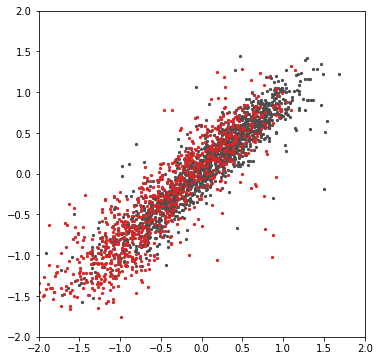

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(to_np(valid_trues.view(-1)), to_np(valid_preds.view(-1)), c='0.3', s=5)

plt.scatter(to_np(nibles_trues.view(-1)), to_np(nibles_preds.view(-1)), c='C3', s=5)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')

In [21]:
root_mean_squared_error(nibles_preds, nibles_trues), root_mean_squared_error(valid_preds, valid_trues)

(tensor(0.3657), tensor(0.2285))